In [23]:
import numpy as np
import cv2
import openslide
import matplotlib.pyplot as plt 
from skimage.filters import threshold_otsu, median
from skimage.morphology import binary_dilation
import torch
import torchvision.transforms as transforms
from PIL import Image


In [2]:
from pathlib import Path

global_dir = Path("D:/CAMELYON16/")
data_dir = global_dir / "data/"
normal_wsi_path = data_dir / "training/normal/"
tumor_wsi_path = data_dir / "training/tumor/"
tumor_mask_path = data_dir / "training/lesion_annotations/"

patch_train_dir = data_dir / "training/"
patch_train_normal_dir = patch_train_dir / "normal/patches"
patch_normal_prefix = "normal_"
patch_normal_index = 0


In [3]:
def read_wsi(directory):
    paths = directory.glob("*.png")
    wsi_images = []
    for path in paths:
        wsi_image = cv2.imread(str(path))
        if wsi_image is not None:
            wsi_images.append(wsi_image)
    return wsi_images

In [8]:
def extract_tissue_with_boxes_COMPLET(rgb_image):
    # Convert RGB image to HSV
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Perform Otsu thresholding on Hue and Saturation channels
    hue_channel = hsv_image[:, :, 0]
    sat_channel = hsv_image[:, :, 1]
    otsu_thresh_hue = threshold_otsu(hue_channel)
    otsu_thresh_sat = threshold_otsu(sat_channel)
    binary_mask_hue = hue_channel <= otsu_thresh_hue
    binary_mask_sat = sat_channel <= otsu_thresh_sat

    # Create the Mask (Hue + Saturation channels)
    binary_mask = binary_mask_hue + binary_mask_sat

    # Mask improvements
    # Apply median filtering to remove spurious regions
    binary_mask = median(binary_mask, np.ones((7, 7)))
    # Dilate to add slight tissue buffer
    binary_mask = binary_dilation(binary_mask, np.ones((5, 5)))

    # Convert to uint8
    binary_mask = (binary_mask + 255).astype(np.uint8)

    # Find contours and create bounding boxes
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.contourArea(contour) > 1000] # Filter small areas
    
    # Draw bounding boxes on the original image
    image_with_boxes = rgb_image.copy()
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)
    
    return binary_mask, bounding_boxes, image_with_boxes

In [10]:
def extract_tissue_with_boxes(rgb_image):
    # Convert RGB image to HSV
    hsv_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    # Perform Otsu thresholding on Hue and Saturation channels
    hue_channel = hsv_image[:, :, 0]
    sat_channel = hsv_image[:, :, 1]
    otsu_thresh_hue = threshold_otsu(hue_channel)
    otsu_thresh_sat = threshold_otsu(sat_channel)
    binary_mask_hue = hue_channel <= otsu_thresh_hue
    binary_mask_sat = sat_channel <= otsu_thresh_sat

    # Create the Mask (Hue + Saturation channels)
    binary_mask = binary_mask_hue + binary_mask_sat

    # Mask improvements
    # Apply median filtering to remove spurious regions
    binary_mask = median(binary_mask, np.ones((7, 7)))
    # Dilate to add slight tissue buffer
    binary_mask = binary_dilation(binary_mask, np.ones((5, 5)))

    # Convert to uint8
    binary_mask = (binary_mask + 255).astype(np.uint8)

    # Find contours and create bounding boxes
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours if cv2.contourArea(contour) > 1000] # Filter small areas
    
    return binary_mask, bounding_boxes

In [11]:
def display_images(images,num_to_display=5):
    plt.figure(figsize=(15, 12))
    for i in range(num_to_display):

        rgb_image = images[i]
        _, bounding_boxes, image_with_boxes= extract_tissue_with_boxes_COMPLET(rgb_image)

        plt.subplot(2, num_to_display, i + 1)
        plt.imshow(image_with_boxes)
        plt.title(f"Image {i+1} with Bounding Boxes")
        plt.axis('off')

        # Display tissue mask
        plt.subplot(2, num_to_display, num_to_display + i + 1)
        plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), cmap='gray')  # Display grayscale version of original image
        for (x, y, w, h) in bounding_boxes:
            rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
            plt.gca().add_patch(rect)
        plt.title(f"Tissue Zones {i+1}")
        plt.axis('off')
    plt.show()

In [12]:
wsi_normal_images = read_wsi(normal_wsi_path)

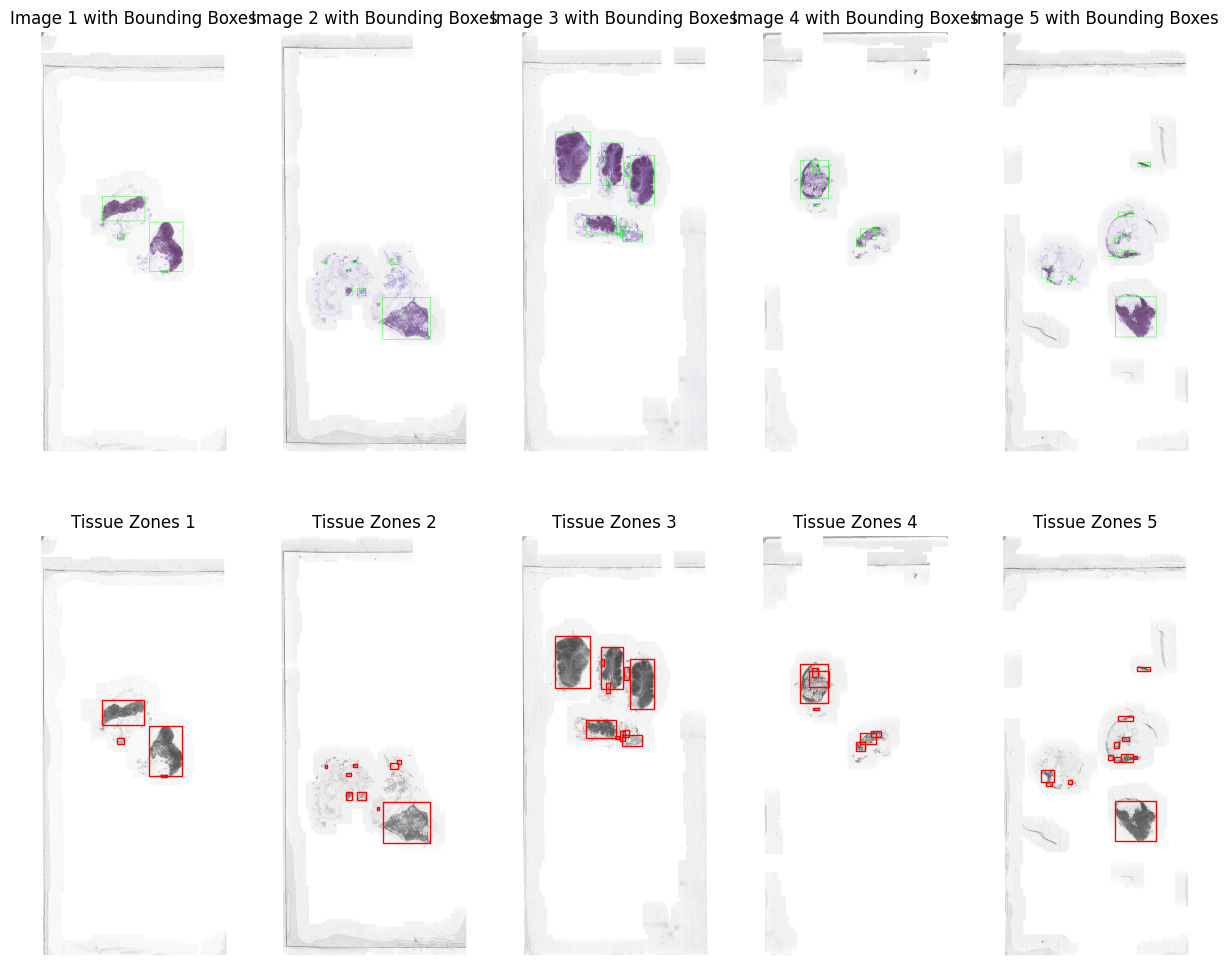

In [9]:
display_images(wsi_normal_images,5)

In [25]:
# Example function to extract negative patches from normal WSI
patch_normal_index = 0
def extract_negative_patches_from_normal_wsi(wsi_image, nb_patch, bounding_boxes, patch_save_dir, patch_prefix, patch_index):
    patch_size = 256  # Example patch size, adjust as needed
    mag_factor = pow(2,6) #level used 6
    for bbox in bounding_boxes:
        x, y, w, h = bbox
        
        for _ in range(nb_patch):
            # Randomly choose patch coordinates within the bounding box
            patch_x = np.random.randint(x, x + w) #MAYBE ADD "- patch_size"
            patch_y = np.random.randint(y, y + h)
            
            # Read region from WSI and convert to RGB array
            #patch_image = np.array(wsi_image.read_region((scaled_x, scaled_y), 0, (patch_size, patch_size)).convert('RGB'))
            patch_image = wsi_image[patch_y:patch_y + patch_size, patch_x:patch_x + patch_size,:]
            # Save patch image
            patch_path = f"{patch_save_dir}/{patch_prefix}_{patch_index}.png"
            cv2.imwrite(patch_path, patch_image)
            patch_index += 1

            augmented_patch = rotate_90(patch_image)
            patch_path = f"{patch_save_dir}/{patch_prefix}_{patch_index}.png"
            cv2.imwrite(patch_path, augmented_patch)
            patch_index += 1

            augmented_patch = random_flip(patch_image)
            patch_path = f"{patch_save_dir}/{patch_prefix}_{patch_index}.png"
            cv2.imwrite(patch_path, augmented_patch)
            patch_index += 1

            augmented_patch = augment_patch_with_color_jitter(patch_image)
            patch_path = f"{patch_save_dir}/{patch_prefix}_{patch_index}.png"
            cv2.imwrite(patch_path, augmented_patch)
            patch_index += 1

    return patch_index

In [26]:
def rotate_90(patch_image):
    #ADD 0 WHEN INTEGRATED TO PIPELINE
    angles = [1, 2, 3]  # Corresponds to 0, 90, 180, 270 degree rotations counter-clockwise.
    angle = np.random.choice(angles)  # Choose a rotation at random.

    # Rotate the image using np.rot90
    rotated_patch_img = np.rot90(patch_image, k=angle)
 
    return rotated_patch_img

In [21]:
def random_flip(patch_image):

    flip_horizontal, flip_vertical = False, False
    
    while (flip_horizontal == False and flip_vertical == False):
        # Randomly decide whether to flip horizontally and/or vertically
        flip_horizontal = np.random.choice([True, False])
        flip_vertical = np.random.choice([True, False])

    # Perform flips if chosen
    if flip_horizontal:
        flipped_patch_img = np.flip(patch_image, axis=1)  # Horizontal flip
    if flip_vertical:
        flipped_patch_img = np.flip(patch_image, axis=0)  # Vertical flip

    return flipped_patch_img

In [28]:
def augment_patch_with_color_jitter(patch_array):

    
    # Define the color jittering transform
    color_jitter = transforms.ColorJitter(
        brightness=0.5,  # Adjust brightness
        contrast=0.5,    # Adjust contrast
        saturation=0.5,  # Adjust saturation
        hue=0.2          # Adjust hue
    )

    # Convert NumPy array to PIL Image
    patch_image = Image.fromarray(patch_array)

    # Apply the color jittering transform
    augmented_patch_image = color_jitter(patch_image)

    # Convert the augmented image back to a NumPy array
    augmented_patch_array = np.array(augmented_patch_image)

    return augmented_patch_array

In [29]:
for wsi_image in wsi_normal_images:
    _, bounding_boxes = extract_tissue_with_boxes(wsi_image)
    patch_normal_index = extract_negative_patches_from_normal_wsi(wsi_image, 3, bounding_boxes, patch_train_normal_dir, patch_normal_prefix, patch_normal_index)